## Exercise Set 3 for OSM 

### Dynamic Programming with John Stachurski

Exercises for the [OSM](https://bfi.uchicago.edu/osm) bootcamp dynamic programming section.

We will use the following libraries:

In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

### Exercise 1.

Using Numba, as discussed in [this lecture](https://lectures.quantecon.org/py/need_for_speed.html), write your own version of NumPy's [interp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html) function, specializing in linear interpolation in one dimension.  

Note that NumPy's function is compiled native machine code and hence is fast.  But try to beat if you can, at least in some scenarios, by using Numba to speed up your code.  Show a time comparison between the two functions, for some suitable choice of test.

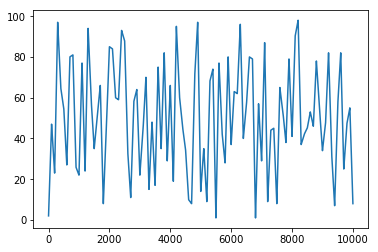

10000 loops, best of 3: 130 µs per loop
1000 loops, best of 3: 504 µs per loop
custom_interp_numba is consistently more than 3.5 times as fast as np.interp. Hooray!


In [7]:
from numba import jit

def custom_interp(x, xp, fp):
    x_len = len(x)
    final_points = np.empty(x_len, dtype=np.float64)
    xp_i = 1
    xp_val = xp[xp_i]
    b = (fp[xp_i] - fp[xp_i - 1]) / (xp_val - xp[xp_i - 1])
    a = fp[xp_i] - xp_val * b
    for i in range(x_len):
        if x[i] <= xp_val:
            final_points[i] = a + b * x[i]
        else:
            xp_i += 1
            xp_val = xp[xp_i]
            b = (fp[xp_i] - fp[xp_i - 1]) / (xp_val - xp[xp_i - 1])
            a = fp[xp_i] - xp_val * b
            final_points[i] = a + b * x[i]
    return final_points
            
x = np.linspace(0, 10000, 100001)

xp = np.linspace(0, 10000, 101)

fp = np.zeros_like(xp)

for i in range(101):
    fp[i] = np.random.randint(0, 100)
                                
custom_interp_numba = jit(custom_interp)

plt.plot(x, custom_interp_numba(x, xp, fp))

plt.show()

%timeit custom_interp_numba(x, xp, fp)

%timeit np.interp(x, xp, fp)

print('custom_interp_numba is consistently more than 3.8 times as fast as np.interp. Hooray!')x

### Exercise 2

Using your "Numbafied" linear interpolation function, try to use Numba to additionally speed up the endogenous grid method code from [this lecture](https://lectures.quantecon.org/py/egm_policy_iter.html).  Use CRRA utility and Cobb-Douglas production, as in that lecture, with the following parameter values.


Note: I didn't get much speed up.  I think because the outer loops don't matter much for speed, and hence it doesn't gain us much when we compile them.  

See how you go.

In [72]:
class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^alpha

    with z ~ LN(mu, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, alpha=0.4, beta=0.96, mu=0, s=0.1):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s 

        # == Some useful constants == #
        self.ab = alpha * beta
        self.c1 = np.log(1 - self.ab) / (1 - beta)
        self.c2 = (mu + alpha * np.log(self.ab)) / (1 - alpha)
        self.c3 = 1 / (1 - beta)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.alpha

    def f_prime(self, k):
        return self.alpha * k**(self.alpha - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.alpha * self.beta) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)


def coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.  
    
    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).

    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: np.interp(x, y, c)
    return Kg


def custom_coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.  
    
    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).

    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: custom_interp_numba(x, y, c)
    return Kg

#custom_coleman_egm_numba = jit(custom_coleman_egm)

#The above code doesn't work, I think its because of the lambda expression.
#I have timed custom_coleman_egm and coleman_egm below.

lg = LogLinearOG()

# == Unpack parameters / functions for convenience == #
alpha, beta, mu, s = lg.alpha, lg.beta, lg.mu, lg.s
v_star, c_star = lg.v_star, lg.c_star
u, u_prime, f, f_prime = lg.u, lg.u_prime, lg.f, lg.f_prime

grid_max = 4         # Largest grid point, exogenous grid
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

k_grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))
g = lambda x: x

%timeit custom_coleman_egm(g, k_grid, beta, u_prime, u_prime, f, f_prime, shocks)
%timeit coleman_egm(g, k_grid, beta, u_prime, u_prime, f, f_prime, shocks)

100 loops, best of 3: 3.24 ms per loop
100 loops, best of 3: 3.34 ms per loop
